# Particle movement in a simple model of a tokamak

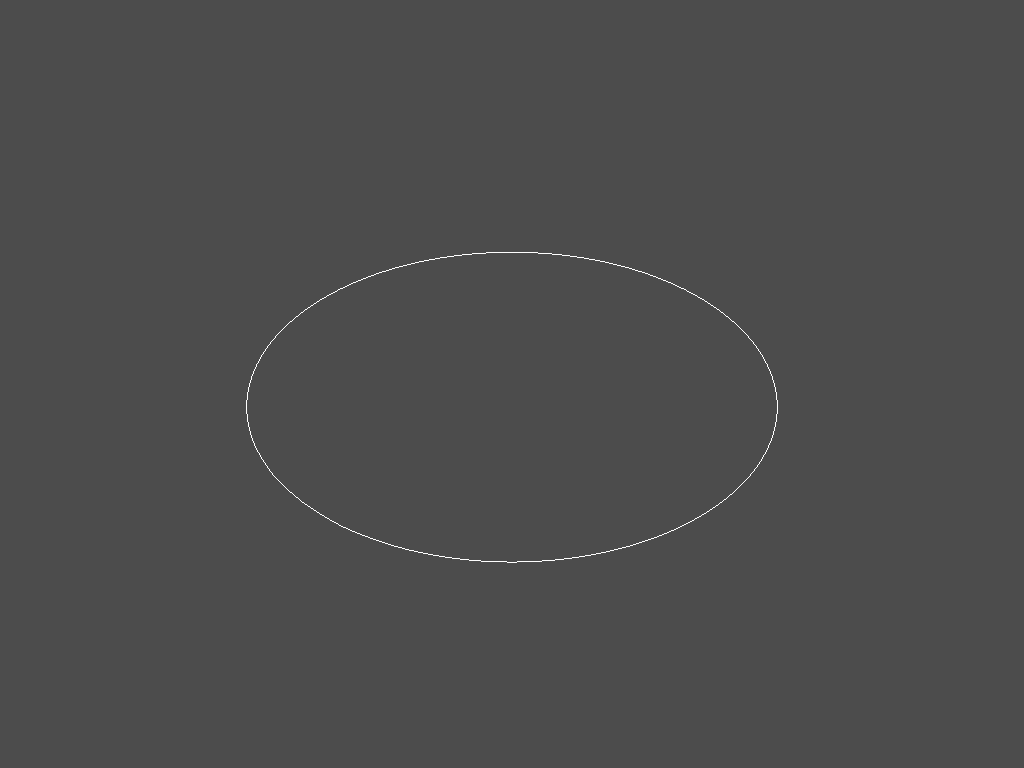

ERROR:root:The interactor must be set prior to enabling/disabling widget


In [1]:
%autoreload 2
from plasmapy import simulation
from plasmapy.formulary import magnetostatics
from plasmapy.classes.sources import Coils
import astropy.units as u
import numpy as np
radius = 0.5 * u.m
main_current = 4 * u.kA
plasma_wire = magnetostatics.CircularWire([0, 0, 1], u.Quantity((0, 0, 0), u.m), radius, main_current)
plasma_wire.visualize()

That's supposed to model just the plasma; let's add a few coils:

In [2]:
pv.Plotter.show?

Object `pv.Plotter.show` not found.


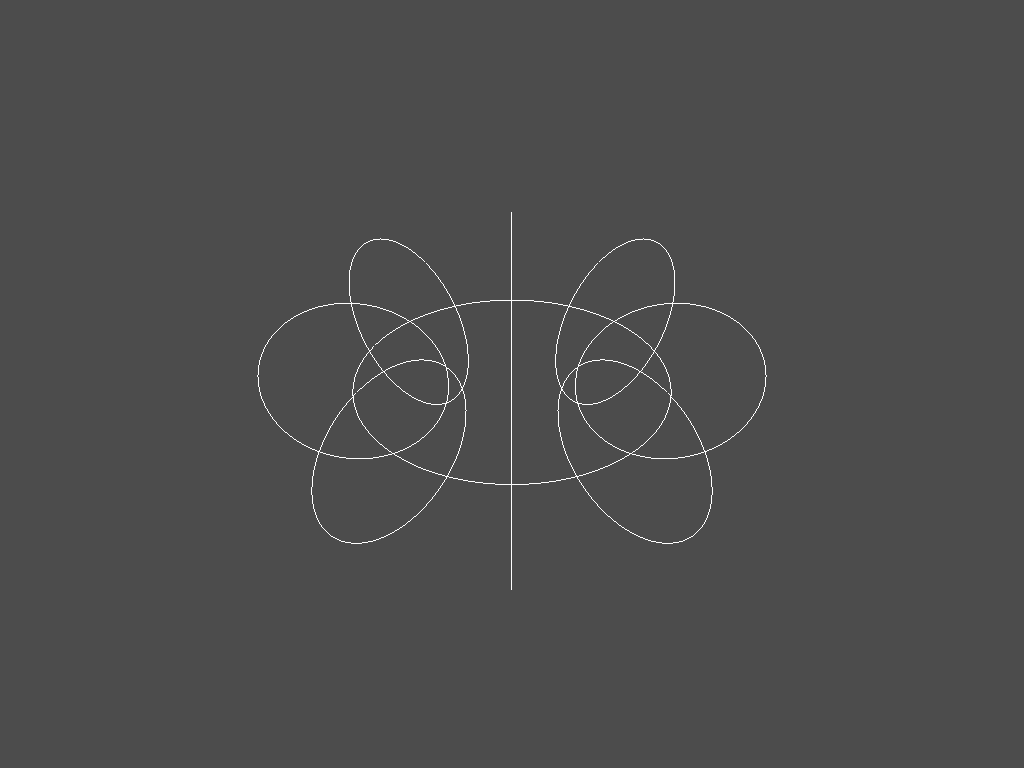

In [3]:
n_coils = 8
currents = n_coils * [4 * u.kA]

coil_angles = np.linspace(0, 2*np.pi, n_coils, endpoint=False)
coil_angles
minor_radius = 0.3 * u.m

coils = []
for i in range(n_coils):
    coil_angle = coil_angles[i]
    x = radius * np.cos(coil_angle)
    y = radius * np.sin(coil_angle)
    normal_angle = np.pi/2 + coil_angle
    normal = u.Quantity([np.cos(normal_angle), np.sin(normal_angle), 0])
    center = u.Quantity([x, y, 0 * u.m])
    coil = magnetostatics.CircularWire(normal, center, minor_radius, currents[i])
    coils.append(coil)
all_currents = coils + [plasma_wire]
c = Coils(*all_currents)
c.visualize()

Note that a shortcut for this model can be quickly accessed as `Coils.toykamak`.

In [4]:
x = u.Quantity([[0.6, 0, 0]],  u.m)
v = u.Quantity([[0, 300, 0]], u.m / u.s)

solution = simulation.ParticleTracker(c, x, v, 'p',).run(1e-1 * u.s, dt = 1e-5 * u.s)
solution

<xarray.Dataset>
Dimensions:         (dimension: 3, particle: 1, time: 1001)
Coordinates:
  * time            (time) float64 0.0 0.00011 0.00021 ... 0.09981 0.09991 0.1
  * particle        (particle) int64 0
  * dimension       (dimension) <U1 'x' 'y' 'z'
Data variables:
    position        (time, particle, dimension) float64 0.6 0.0 ... -0.03678
    velocity        (time, particle, dimension) float64 -64.52 217.3 ... -86.12
    B               (time, particle, dimension) float64 1.084e-19 ... -0.004752
    E               (time, particle, dimension) float64 0.0 0.0 0.0 ... 0.0 0.0
    timestep        (time) float64 1e-05 1e-05 1e-05 1e-05 ... 1e-05 1e-05 1e-05
    kinetic_energy  (time, particle) float64 7.527e-23 7.527e-23 ... 7.527e-23
Attributes:
    particle:          p+
    total_iterations:  10001

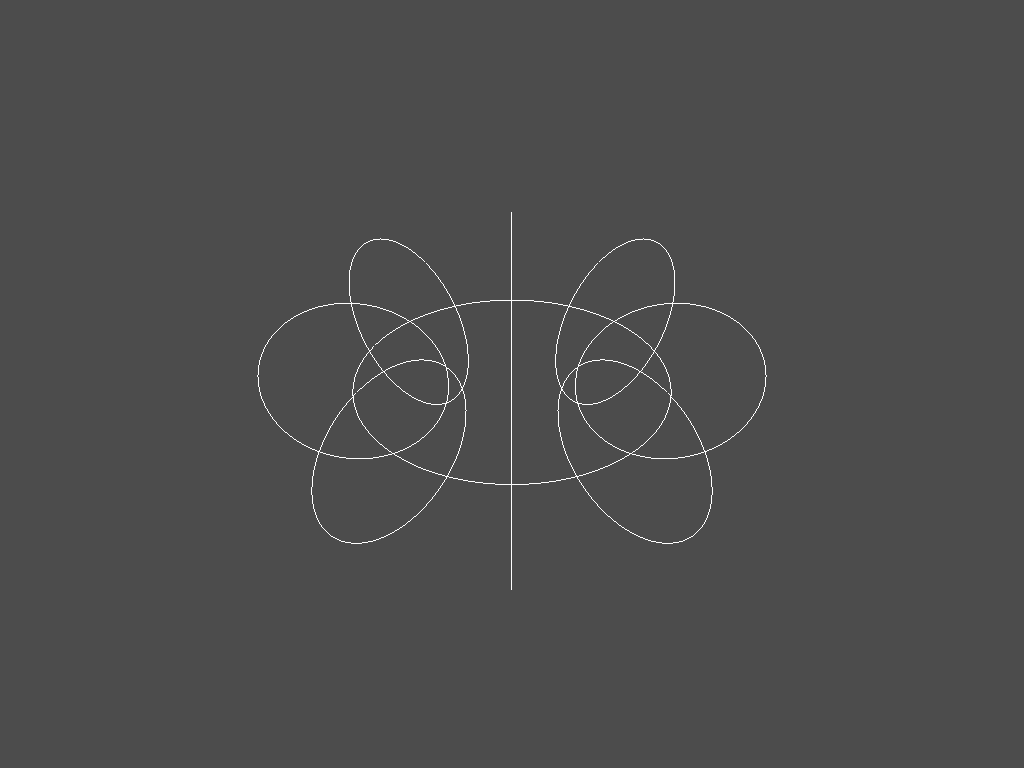

ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')

In [5]:
solution.particletracker.animate("toykamak.mp4", nframes = 1000, notebook_display = True, plasma=c)

In [ ]:
solution.sel(particle=0).particletracker.vector_norm('B', 'dimension').plot.line();

In [ ]:
solution_electron = simulation.ParticleTracker(c, x, v, 'e-').run(1 * u.s, dt = 1e-5 * u.s)
solution_electron

In [ ]:
fig = pv.PlotterITK()
points = solution_electron.position.sel(particle=0).values
spline = pv.Spline(points, max((1000, solution.sizes['time']//100)))
fig.add_mesh(spline,
             scalars = np.linspace(solution.time.min(), solution.time.max(), spline.n_points),
             # stitle="Time [s]",
             # name = "Trajectory",
            )
c.visualize(fig)
fig.show()

Let's see how the timestep affects the results' accuracy.

In the future, this might be alleviated by an adaptive time step; unfortunately, Boris solvers lose 

In [ ]:
solution2 = sim.run(1e-2 * u.s, 1e-5 * u.s, pusher='implicit_boris')

fig = pv.Plotter(notebook=True)
c.visualize(fig)
solution2.visualize(fig)
fig.show(use_panel=True, auto_close = False)

In [ ]:
solution3 = sim.run(1e-2 * u.s, 1e-5 * u.s, pusher='zenitani')

fig = pv.Plotter(notebook=True)
c.visualize(fig)
solution3.visualize(fig)
fig.show(use_panel=True, auto_close = False)

In [ ]:
x = u.Quantity([[1 + minor_radius.si.value / 2, 0, 0]],  u.m)
v = u.Quantity([[10000, 10000, 1000000]], u.m / u.s)

banana_sim = simulation.ParticleTracker(c, x, v, 'e',)
banana_solution = banana_sim.run(1e-8 * u.s, 1e4)
banana_solution.plot_time_trajectories()
fig = mlab.figure(size=(800, 600))
c.visualize(fig)
banana_solution.visualize(fig)
mlab.orientation_axes(figure=fig)
fig

In [ ]:
solution2_unstable = sim.run(1e-4 * u.s, int(3e4))

fig = mlab.figure()
c.visualize(fig)
solution2_unstable.visualize(fig)
mlab.orientation_axes(figure=fig)
fig

In [ ]:
solution2_unstable.plot_time_trajectories()

In [ ]:
x2 = u.Quantity([[1 + minor_radius.si.value / 2, 0, 0]],  u.m)
v2 = u.Quantity([[0, 10000, 0]], u.m / u.s)

sim2 = simulation.ParticleTracker(c, x2, v2, 'e', )
solution3 = sim.run(1e-8 * u.s, int(3e5))

fig2 = mlab.figure()
c.visualize(fig2)
solution3.visualize(fig2)
mlab.orientation_axes(figure=fig2)
display(fig2)

In [ ]:
N = 30
xmany = u.Quantity(N*[[1 + minor_radius.si.value / 2, 0, 0]],  u.m)
vmany = np.array(N*[[0, 10000, 0]], dtype=float)
vmany[:, 2] = np.random.normal(size=N)
vmany = u.Quantity(vmany, u.m / u.s)

simmany = simulation.ParticleTracker(c, x2, v2, 'e', )
solutionmany = simmany.run(1e-8 * u.s, int(3e5))

fig2 = mlab.figure()
c.visualize(fig2)
solutionmany.visualize(fig2)
mlab.orientation_axes(figure=fig2)
display(fig2)

In [ ]:
solutionmany.plot_time_trajectories('xy') 

In [ ]:
solutionmany.plot_time_trajectories()